In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner, DoubleTabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
def generate_population(population):
    agents = [
        DoubleTabularQLearner(
            lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.99
        )
        for _ in range(population)
    ]

    G = nx.complete_graph(population)

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [3]:
# _, _, G = generate_population(32)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [4]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1) if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None
        else "OTHER"
        for policy in policies
    ]


def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [5]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

Run 1:   0%|          | 0/10000 [00:00<?, ?it/s]

BEST AGENT (112): 60493 (0.9507284030806347, CCCCCCCCCCCCCCCC)
WORST AGENT (36): 47083 (0.5691371285356248, DCDCCCCCCCCCCCCC)


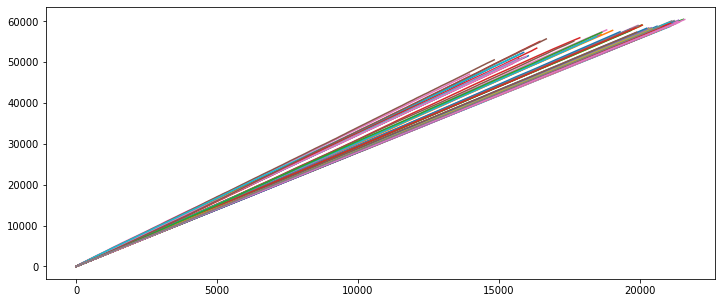

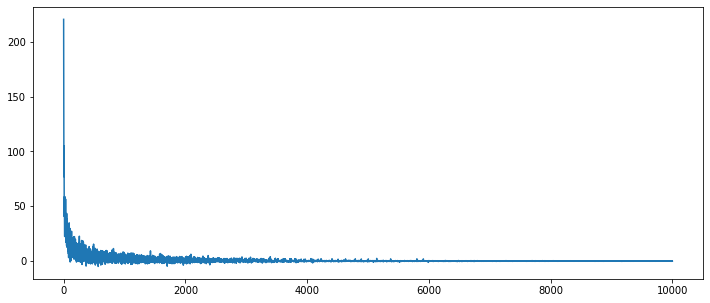

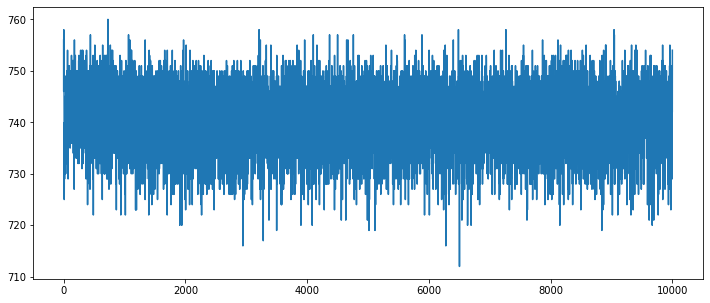

In [6]:
POPULATION = (128,)
ROUNDS = 10_000

run_rewards = []
run_cumulative_rewards = []
run_reward_histories = []
run_policies = []

for run in range(1):
    epoch_rewards = []

    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        r = sim.play_round(train=True)
        epoch_rewards.append(r)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(sim.reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))

    plt.show()

    plt.plot(sim.differences)
    plt.show()

    plt.plot(epoch_rewards)
    plt.show()

In [7]:
G = nx.from_numpy_matrix(
    np.matrix(sim.produce_weight_matrix()), create_using=nx.DiGraph
)

In [8]:
from datetime import datetime

dt = datetime.isoformat(datetime.now()).replace(":", "-").replace("T", " ")

nx.drawing.nx_pydot.write_dot(G, f"{dt}.dot")

In [9]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [10]:
weights = sim.calculate_weights()

weights

array([[0.05      , 0.37869822, 0.34027778, ..., 0.28329865, 0.38012324,
        0.34027778],
       [0.37869822, 0.05      , 0.51803319, ..., 0.45529739, 0.61734694,
        0.43312148],
       [0.34027778, 0.51803319, 0.05      , ..., 0.45055357, 0.80899473,
        0.85207101],
       ...,
       [0.28329865, 0.45529739, 0.45055357, ..., 0.05      , 0.29843964,
        0.41791654],
       [0.38012324, 0.61734694, 0.80899473, ..., 0.29843964, 0.05      ,
        0.80055402],
       [0.34027778, 0.43312148, 0.85207101, ..., 0.41791654, 0.80055402,
        0.05      ]])

In [11]:
K = nx.Graph()
K.add_weighted_edges_from(
    [
        (i, j, weights[i, j] + weights[j, i])
        for i in range(POPULATION[0])
        for j in range(i + 1, POPULATION[0])
        if i != j and weights[i, j] > 0.7 and weights[j, i] > 0.7
    ]
)

nx.drawing.nx_pydot.write_dot(K, f"{dt} - reduced.dot")

In [12]:
sim.action_histories[0][2]

[<Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFE

In [13]:
cumulative_rewards[0][0]

112

In [14]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[374.01188364 320.43353521]
  [357.36348222 110.25782848]
  [339.90932561  79.79514834]
  [119.98959944   1.26906491]]

 [[367.6680515  177.21506942]
  [324.0274644    4.64989023]
  [222.73383361   2.82635025]
  [ 34.3623259    0.        ]]

 [[365.63214593 117.6002749 ]
  [251.64535428  16.34511651]
  [186.08232445   2.10207043]
  [ 16.57456483   0.        ]]

 [[256.89945509  10.39734572]
  [ 98.89426106   0.        ]
  [ 22.20453423   0.        ]
  [  0.           0.        ]]]


In [15]:
agents[cumulative_rewards[4][0]].play_move(
    [Action.COOPERATE, Action.COOPERATE], [Action.COOPERATE, Action.COOPERATE]
)

<Action.COOPERATE: 0>

In [16]:
if hasattr(agents[1], "_q_table"):
    print(agents[1]._q_table)

[[[299.92794239 246.82515336]
  [278.9304241   44.82685129]
  [263.94658189 126.24632598]
  [216.8913532    8.40562238]]

 [[291.50766684 131.22104527]
  [220.98911916  13.96904369]
  [125.93774814   3.21756886]
  [ 47.78523759   0.        ]]

 [[246.97510383 264.07101961]
  [239.06459616  11.41492193]
  [194.28816521   7.49319211]
  [ 54.66757846   0.        ]]

 [[269.0689011   41.16277102]
  [ 79.56313884   0.        ]
  [ 50.5980462    1.69276073]
  [  2.99317681   0.        ]]]


In [17]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)

In [18]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {
    policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()
}
mean_cumulative_reward_policies = {
    policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()
}

In [19]:
for policy in sorted(
    mean_cumulative_reward_policy_ranks,
    key=lambda x: mean_cumulative_reward_policy_ranks[x],
):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

11.0                     CCCCCDCCCCCCCCCC
15.0                     CCCCCDCCCCCDCCCC
16.0                     CCCDCCCDCCCCCCCD
18.0                     CCCCCCCDCCCCCCCC
29.0                     CCCCCCCCCCCDCCDC
38.0                     CCCCCCCCCCCCCDCC
38.5                     CCCDCCCCCCCCDCCD
39.0                     CCCDCCCCCCCDCCCC
39.02325581395349        CCCCCCCCCCCCCCCC
48.0                     CCCCCCCCCCCCDCCC
48.0                     CCCCCCCCCCCCCCDC
49.0                     CCCDCCCDCCCCCCCC
52.333333333333336       CCCCCCCCCCCDCCCC
54.0                     CDCCCCCCCDCCCCCC
59.0                     CCCCCCCDCDCCCCCC
61.5                     CCCDCCCCCCCCCCCC
64.0                     CCCCCDCCCCCCCCDC
64.8                     CCCCDCCCCCCCCCCC
65.0                     CCCCCDDDCCCCCCCC
67.0                     CCCCDCCCCCCDCCCC
69.0                     CCCCCCCCCDCCCCCC
69.0                     CCCDCCCCCDCCCCCC
72.0                     CCCCCCCDCCCCCCDC
75.5                     CDCCCCCCC

In [20]:
for policy in sorted(
    mean_cumulative_reward_policies,
    key=lambda x: mean_cumulative_reward_policies[x],
    reverse=True,
):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

59927.0                  CCCCCDCCCCCCCCCC
59791.0                  CCCCCDCCCCCDCCCC
59742.0                  CCCDCCCDCCCCCCCD
59621.0                  CCCCCCCDCCCCCCCC
59444.0                  CCCCCCCCCCCDCCDC
59366.333333333336       CCCCCCCCCCCCCDCC
59316.79069767442        CCCCCCCCCCCCCCCC
59257.5                  CCCDCCCCCCCCDCCD
59252.0                  CCCDCCCCCCCDCCCC
59097.0                  CCCDCCCDCCCCCCCC
59096.5                  CCCCCCCCCCCCDCCC
59073.0                  CCCCCCCCCCCCCCDC
59049.333333333336       CCCCCCCCCCCDCCCC
59011.0                  CDCCCCCCCDCCCCCC
58959.0                  CCCCCCCDCDCCCCCC
58823.0                  CCCCCDCCCCCCCCDC
58813.0                  CCCCCDDDCCCCCCCC
58796.0                  CCCDCCCCCCCCCCCC
58793.0                  CCCCDCCCCCCDCCCC
58754.0                  CCCDCCCCCDCCCCCC
58735.0                  CCCCCCCDCCCCCCDC
58681.6                  CCCCDCCCCCCCCCCC
58574.0                  CCCCCCCCCDCCCCCC
58560.0                  CCCCCCDCC

In [21]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'CCCCCCCCCCCCCCCC'

In [22]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[374.01188364 320.43353521]
  [357.36348222 110.25782848]
  [339.90932561  79.79514834]
  [119.98959944   1.26906491]]

 [[367.6680515  177.21506942]
  [324.0274644    4.64989023]
  [222.73383361   2.82635025]
  [ 34.3623259    0.        ]]

 [[365.63214593 117.6002749 ]
  [251.64535428  16.34511651]
  [186.08232445   2.10207043]
  [ 16.57456483   0.        ]]

 [[256.89945509  10.39734572]
  [ 98.89426106   0.        ]
  [ 22.20453423   0.        ]
  [  0.           0.        ]]]


In [23]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => C
('(C, C)', '(C, D)') => C
('(C, C)', '(D, C)') => C
('(C, C)', '(D, D)') => C
('(C, D)', '(C, C)') => C
('(C, D)', '(C, D)') => C
('(C, D)', '(D, C)') => C
('(C, D)', '(D, D)') => C
('(D, C)', '(C, C)') => C
('(D, C)', '(C, D)') => C
('(D, C)', '(D, C)') => C
('(D, C)', '(D, D)') => C
('(D, D)', '(C, C)') => C
('(D, D)', '(C, D)') => C
('(D, D)', '(D, C)') => C
('(D, D)', '(D, D)') => C
